In [1]:
from model import build_pipeline, build_pipeline_rf, get_evaluator, train_model
from pyspark.sql import functions as F
from collate import weather_process
from clean import run_clean
from _global_vars import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

22/11/22 22:27:05 WARN Utils: Your hostname, LAPTOP-VAB0S7AL resolves to a loopback address: 127.0.1.1; using 172.31.199.143 instead (on interface eth0)
22/11/22 22:27:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/22 22:27:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/22 22:27:08 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# Change for full model or subsample
subsample = True
fit_models = True

# weather data location path
weather_date_path = "../data/raw/nyc_weather_date/NYC_2019onwards.csv"

In [3]:
# read in cleaned sdf
sdf = spark.read.parquet('../data/curated/yt2019_cleaned.parquet')
print("full dataset counts: " + str(sdf.count()))

# in development use sampled training set: '2019 NYC Yellow Taxi Data'
if subsample:
    train = sdf.sample(fraction=0.1, seed=0)
    print("subsampled dataset counts: " + str(train.count()))
else:
   train = sdf

full dataset counts: 2541382
subsampled dataset counts: 12757


In [4]:
model_features = ['VendorID',
                  'passenger_count',
                  'trip_distance',
                  'RatecodeID',
                  'PULocationID',
                  'DOLocationID',
                  'payment_type',
                  'congestion_surcharge',
                  'PU_hourofday',
                  'DO_hourofday',
                  'PU_dayofweek',
                  'DO_dayofweek',
                  'PU_dayofmonth',
                  'PU_month',
                  'DO_month',
                  'trip_time_minutes',
                  'trip_speed_mph',
                  'tmpf','dwpf','relh']

In [5]:
# chosen subset of features used in modelling
sdf.columns

['hour_of_day_of_year',
 'VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'tip_amount',
 'congestion_surcharge',
 'PU_datetime',
 'DO_datetime',
 'PU_hourofday',
 'DO_hourofday',
 'PU_dayofweek',
 'DO_dayofweek',
 'PU_dayofmonth',
 'DO_dayofmonth',
 'PU_month',
 'DO_month',
 'trip_time_minutes',
 'trip_speed_mph',
 'fare_per_minute',
 'tmpf',
 'dwpf',
 'relh',
 'is_valid_record']

### Load/Build Pipeline

Build the pipeline, train the model and export

In [6]:
# get pipeline objects
pipeline = build_pipeline(model_features)
pipeline_rf = build_pipeline_rf(model_features)

In [7]:
if fit_models:
    # train the model on the dataset
    model = train_model(train, pipeline) #GBT
    model2 = train_model(train, pipeline_rf) #RF

    # save the models
    if subsample:
        model.write().overwrite().save('../models/GBTModel_2019_subsampled')
        model2.write().overwrite().save('../models/RFModel_2019_subsampled')
    else:
        model.write().overwrite().save('../models/GBTModel_2019')
        model2.write().overwrite().save('../models/RFModel_2019')
else:
    # load the models from disk
    # NOTE: if running models from a different server need to remove .crc files
    if subsample:
        model = pipeline.load(path='../models/GBTModel_2019_subsampled')
        model2 = pipeline_rf.load(path='../models/RFModel_2019_subsampled')
    else:
        model = pipeline.load(path='../models/GBTmodel_2019')
        model2 = pipeline_rf.load(path='../models/RFmodel_2019')

Transform 2021 datasets for evaluation

In [8]:
# TODO IMPLEMENT SUBSAMPLING HERE?

In [9]:
# read in raw 2021 taxi+weather data & confirm
sdf_2021 = spark.read.parquet('../data/raw/tlc_data/tlc_data_yellow/2021*')

# read and process weather data
weather_sdf = spark.read.csv(weather_date_path, header=True, inferSchema=True)
weather_sdf = weather_process(weather_sdf)

In [10]:
print("Before cleaning: ", sdf_2021.count())
sdf_2021 = run_clean(sdf_2021)
print("After cleaning: ", sdf_2021.count())

Before cleaning:  1369769


After cleaning:  1160569


In [11]:
# join weather and taxi datasets
sdf_2021_comb = sdf_2021.join(weather_sdf, on=['hour_of_day_of_year'], how='inner')

Get model predictions and inspect feature importances

In [12]:
preds_2021 = model.transform(sdf_2021_comb)
preds_2021_rf = model2.transform(sdf_2021_comb)

Evaluate model predictions

In [13]:
# Source: timlrx.com/blog/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator
def extract_feature_imp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return varlist.sort_values('score', ascending = False)

In [14]:
def evaluate_predictions(m, p, name):
    # get evaluator
    e = get_evaluator("rmse")
    rmse = e.evaluate(p)
    print(f"Root Mean Squared Error (RMSE) on 2021 test data ({name}) = {rmse}")

    e.setMetricName("mae")
    mae = e.evaluate(p)
    print(f"Mean Absoulute Error (MAE) on 2021 test data ({name}) = {mae}")

    e.setMetricName("mse")
    mse = e.evaluate(p)
    print(f"Mean Squared Error (MAE) on 2021 test data ({name}) = {mse}")

    e.setMetricName("var")
    var = e.evaluate(p)
    print(f"Explained Variance (VAR) on 2021 test data ({name}) = {var}")

    e.setMetricName("r2")
    r2 = e.evaluate(p)
    print(f"R2 on 2021 test data ({name}) = {r2}")

    # get raw feature importance' from model
    fi = m.stages[1].featureImportances

    # display fi's
    print(extract_feature_imp(fi, p, "features").round(decimals=4).head(4))

    pass

In [15]:
# evaluate GBT models predictions
evaluate_predictions(model, preds_2021, "GBT")

22/11/22 22:27:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/22 22:27:42 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Root Mean Squared Error (RMSE) on 2021 test data (GBT) = 1.5684762977153541


Mean Absoulute Error (MAE) on 2021 test data (GBT) = 0.6953042955631


Mean Squared Error (MAE) on 2021 test data (GBT) = 2.460117896494864


Explained Variance (VAR) on 2021 test data (GBT) = 55.3146908604567


R2 on 2021 test data (GBT) = 0.956882125625404
    idx               name   score
2     2      trip_distance  0.7497
15   15  trip_time_minutes  0.2257
16   16     trip_speed_mph  0.0154
5     5       DOLocationID  0.0030


In [16]:
# evaluate RF models predictions
evaluate_predictions(model2, preds_2021_rf, "RF")

Root Mean Squared Error (RMSE) on 2021 test data (RF) = 1.7473967475262557


Mean Absoulute Error (MAE) on 2021 test data (RF) = 0.7351766667941754


Mean Squared Error (MAE) on 2021 test data (RF) = 3.0533953932653373


Explained Variance (VAR) on 2021 test data (RF) = 45.48627346901265


R2 on 2021 test data (RF) = 0.9464838985276411
    idx               name   score
2     2      trip_distance  0.5191
15   15  trip_time_minutes  0.3735
16   16     trip_speed_mph  0.0752
4     4       PULocationID  0.0214


---
### Error analysis
---

##### Gradient Boosted Tree Model

In [17]:
preds_2021 = preds_2021.withColumn(
    'prediction_error',
    (F.col('fare_amount') - (F.col('prediction')))
)

In [18]:
preds_2021.select("prediction", "fare_amount", 'prediction_error',"features").show(5)

22/11/22 22:28:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------+-----------+-------------------+--------------------+
|        prediction|fare_amount|   prediction_error|            features|
+------------------+-----------+-------------------+--------------------+
| 7.487162799707639|        8.0| 0.5128372002923607|[1.0,1.0,2.1,1.0,...|
| 46.46454789328134|       42.0| -4.464547893281342|[1.0,1.0,14.7,1.0...|
| 15.91080474963585|       16.5| 0.5891952503641509|[2.0,1.0,4.94,1.0...|
| 7.563133987396279|        8.0|0.43686601260372093|[1.0,1.0,1.6,1.0,...|
|15.627538136575591|       16.0| 0.3724618634244088|[1.0,1.0,4.1,1.0,...|
+------------------+-----------+-------------------+--------------------+
only showing top 5 rows



In [19]:
# export predictions errors? -> never -> graph them instead
preds_df = preds_2021 \
                    .select("prediction",
                                "fare_amount",
                                'prediction_error') \
                    .sample(fraction=0.005, seed=0) \
                    .toPandas()

In [20]:
# remove extremely wrong predictions for visualisations
preds_df_cull = preds_df[preds_df['prediction_error'] <= 60]

<AxesSubplot:xlabel='prediction_error', ylabel='Density'>

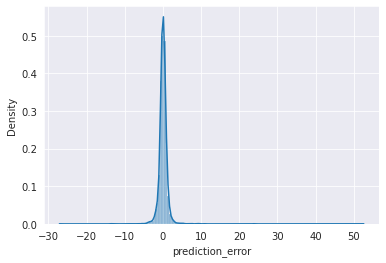

In [21]:
sns.histplot(x=preds_df_cull['prediction_error'], bins=200, kde=True, stat='density')

<AxesSubplot:xlabel='prediction_error'>

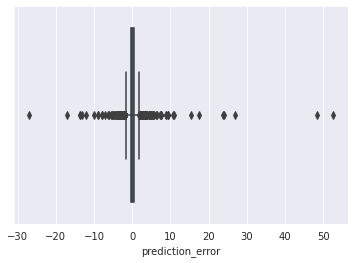

In [22]:
sns.boxplot(x=preds_df_cull['prediction_error'])
#sns.boxplot(x=preds_df_cull['fare_amount'])

Predictions vs true fare amounts distributions

In [23]:
(preds_df_cull['prediction_error'] <= 0).describe()

count      5849
unique        2
top       False
freq       3094
Name: prediction_error, dtype: object

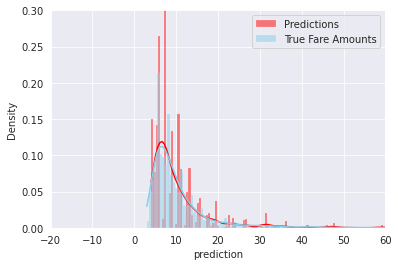

In [26]:
sns.histplot(x=preds_df_cull['prediction'],  bins=200, kde=True, stat='density', color="red", label="Predictions")
sns.histplot(x=preds_df_cull['fare_amount'],  bins=200, kde=True, stat='density', color="skyblue", label="True Fare Amounts")
plt.legend()
plt.xlim(-20, 60)
plt.ylim(0, 0.3)
#plt.show()
plt.savefig('../plots/preds_vs_true.png', dpi=300)

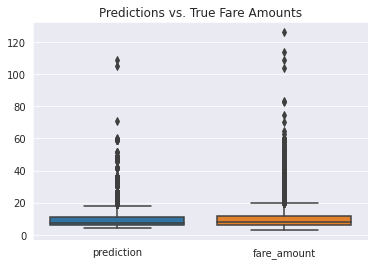

In [25]:
preds_boxplot_df = preds_df_cull[['prediction', 'fare_amount']]
preds_vs_fare = sns.boxplot(data=preds_boxplot_df)
plt.title("Predictions vs. True Fare Amounts")
#plt.legend()
plt.savefig('../plots/preds_vs_fare_boxplot.png')